# Versionamento

V2: 
<ul>
    <li>Inclusão da variável categórica x28 que está relacionada com o tipo de papel em produção</li>
    <li>Feature Selection</li>
    <li>Feature Scalling</li>
</ul>

V3:
<ul>
    <li>Ajuste de parâmetros dos modelos</li>
    <li> V2: correção da função lstm_data_transform para pegar o target correto</li>
</ul>

V4:
<ul>
    <li>Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS) </li>
    <li>num_steps de 30 para 10</li>
</ul>

# O problema

Paper manufacturing can be viewed as a continuous rolling process. During this process, sometimes the paper breaks. If a break happens, the entire process is stopped, the reel is taken out, any found problem is fixed, and the production is resumed. The resumption can take more than an hour.

The cost of this lost production time is significant for a mill. Even a 5% reduction in the break events will give a significant cost saving for a mill. The objective of the given problem is to predict such breaks in advance (early prediction) and identify the potential cause(s) to prevent the break. 

To build such a prediction model, we will use the data collected from the network of sensors in a mill.

This is a multivariate time series data with break as the response (a
binary variable).
The provided data has,
<ul>
    <li>18,398 records.</li>
    <li>Columns:</li>
        <ul>
        <li>time: the timestamp of the row</li>
        <li>y: the binary response variable. There are only 124 rows with y = 1, rest are y = 0.</li>
        <li>x1-x61: predictor variables. All the predictors are continuous variables, except x28 and x61. x61 is a binary variable, and x28 is a
        categorical variable. All the predictors are centered. Besides, the predictors are a mixture of raw materials and process variables. Their descriptions are omitted for data anonymity.
            Several sensors are placed in different parts of the machine along its length
and breadth. These sensors measure both raw materials (e.g. amount of pulp
fiber, chemicals, etc.) and process variables (e.g. blade type, couch vacuum,
rotor speed, etc.).</li>
        </ul>
</ul>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, plot_confusion_matrix
import datetime

# Load Data

In [2]:
pwbdatafile = '..\\data\\pwb-data-augmented.csv'
pwbds = pd.read_csv(pwbdatafile)
pwbds.drop('Unnamed: 0',axis=1,inplace=True)

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [3]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['timestamp'].tolist())

In [4]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['timestamp'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [5]:
pwbds.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x54,x55,x56,x57,x58,x59,x60,x61,timestamp,nextbreaktime
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,0,259
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,1,259
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,2,259
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,3,259
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,4,259


In [6]:
pwbds['RUL']=(pwbds['nextbreaktime']-pwbds['timestamp'])
#pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['timestamp','nextbreaktime'], axis=1, inplace=True)

In [7]:
pwbds.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,...,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0,259
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,...,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0,258
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,...,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0,257
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,...,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0,256
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,...,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0,255


### Verificando cálculo do RUL

In [8]:
pwbds[pwbds.y==1]

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
259,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,-0.030057,...,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1,0
776,1,-0.782471,-12.118747,-16.855194,-322.781610,-0.738810,25.966042,0.040711,-0.071186,0.012574,...,-5.337590,2.680329,-7.209775,-37.195777,1.642284,0.013798,2.664362,0.007856,0,0
835,1,-0.697450,-1.696176,4.145142,121.152838,-0.598597,-7.789024,0.060853,0.048752,-0.120087,...,-6.368351,2.568616,-26.245907,-74.477362,-0.097279,0.015905,2.700281,0.007745,0,0
1036,1,-0.791718,-0.076644,-1.012134,162.257269,-0.062876,9.005471,0.005767,0.033764,-0.120087,...,-6.856144,2.703874,-29.833432,-53.421866,-1.165393,0.019691,3.348276,0.006241,0,0
1263,1,-1.212083,-2.326809,0.922287,31.935858,-0.920100,14.183205,-0.089298,0.028915,-0.120087,...,-6.856144,2.762956,0.965763,-49.512961,-0.219349,0.041640,2.740404,0.005131,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52626,1,-0.367076,-8.876281,-9.826331,-81.548181,0.719656,-31.805839,-0.058545,-0.000993,0.009922,...,10.091365,3.105512,101.055728,-59.396201,-2.111499,0.001227,1.458925,0.018978,0,0
52630,1,0.381548,-7.119146,-7.791697,-68.089395,0.172140,-61.932670,0.000732,-0.101094,0.009922,...,5.405574,-5.013181,-46.756772,-52.525641,-0.860218,0.016202,3.409899,0.007643,0,0
52708,1,0.386066,-9.029249,-8.759439,83.883705,-0.509745,52.357521,0.180791,0.268791,0.139931,...,1.914363,3.143712,18.257755,-72.250327,-1.775806,-0.149790,-0.102720,0.000803,1,0
52892,1,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,...,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596,0,0


In [9]:
pwbds.iloc[257:262,][['y','RUL']]

,y,RUL
257,0,2
258,0,1
259,1,0
260,0,516
261,0,515


### Remove Break Avalanche

In [10]:
def removeBreakAvalanche (fullds):
    clean_ds = pd.DataFrame([])
    breaks = np.array(np.where(pwbds['y'] == 1)).reshape(-1)
    start = 0 
    for breakpt in breaks:
        if (breakpt-start >= 30):
            clean_ds = clean_ds.append(fullds.iloc[start:breakpt+1,],ignore_index = True)
        start = breakpt+1
    return (clean_ds)

In [11]:
clean_ds = removeBreakAvalanche(pwbds)

## Marcação de falha no próximo período (próxima hora)

Using RUL, we can create a label indicating time to failure. We define a boolean (True\False) value for NEXT_H indicating the engine will fail within 60 minutes (RUL  <=60 ). 

We can also define a multiclass MULTI  ∈{0,1,2}  indicating {Healthy, RUL <=60, RUL <=120} minutes.

In [12]:
clean_ds['NEXT_H'] = np.where(clean_ds['RUL'] <= 60, 1, 0 )

In [13]:
clean_ds['NEXT_H'].value_counts()

0    37592
1    13620
Name: NEXT_H, dtype: int64

### Verificando a marcação de falha na próxima hora

In [14]:
clean_ds.iloc[228:262,][['y','RUL','NEXT_H']]

,y,RUL,NEXT_H
228,0,31,1
229,0,30,1
230,0,29,1
231,0,28,1
232,0,27,1
233,0,26,1
234,0,25,1
235,0,24,1
236,0,23,1
237,0,22,1


# Feature Selection and Scaling

In [15]:
corrmat = clean_ds.corr()
corrmat.loc['RUL',].sort_values().head(20)

NEXT_H   -0.588799
x4       -0.313762
x24      -0.172275
x48      -0.171677
x28      -0.133086
x49      -0.097299
x60      -0.088347
y        -0.079818
x46      -0.077195
x45      -0.067877
x34      -0.065293
x6       -0.041568
x42      -0.032789
x61      -0.029354
x15      -0.019570
x23      -0.018657
x38      -0.017668
x30      -0.017249
x33      -0.004398
x9       -0.003474
Name: RUL, dtype: float64

In [16]:
corrmat.loc['RUL',].sort_values().tail(20)

x13    0.118777
x16    0.129807
x57    0.130940
x11    0.132080
x12    0.141796
x21    0.145788
x1     0.156287
x27    0.156848
x50    0.160561
x8     0.165457
x47    0.168285
x52    0.173944
x54    0.175197
x37    0.179483
x44    0.187198
x26    0.206558
x29    0.220890
x2     0.233275
x55    0.251456
RUL    1.000000
Name: RUL, dtype: float64

In [17]:
# Feature Selection
# List of considered Features

FEATURES = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x28','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60'
#]
# Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS)
#    'x1','x5','x8','x10','x13','x14','x15','x17','x18','x19','x20','x21','x22','x26','x28','x30','x31','x34',
#    'x35','x37','x38','x40','x41','x43','x46','x48','x49','x51','x53','x54','x55','x58'

# Usando as features com base na sua relação com RUL
#    'x4','x24','x48','x58','x60','x42','x45','x61','x46','x49','x9','x10','x38','x17','x5','x28','x33','x41',   
#    'x13','x16','x56','x8','x12','x1','x57','x50','x44','x47','x52','x27','x37','x3','x54','x26','x2','x29','x55'

# Cj 1 - Não usar: derrubou métricas quando adicionado ao Cj 4 + Cj 6
#    'x1','x2','x4','x5','x6','x7','x10', 'x11','x13','x15','x17','x28',
#    'x1','x5','x10','x13','x14','x15',
    
# Cj 2
# Medidos sem C3:
#    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25', # Precision: 0.781, Recall: 0.390, F1: 0.520
#    'x3','x8','x10','x12','x13','x16',                               # Precision: 0.834, Recall: 0.375, F1: 0.518
#    'x18','x19','x20','x23','x25',                                   # Precision: 0.980, Recall: 0.156, F1: 0.269
#    'x3','x8','x10','x18','x19','x20',                               # Precision: 0.848, Recall: 0.251, F1: 0.387
#    'x12','x13','x16','x23','x25',                                   # Precision: 0.900, Recall: 0.218, F1: 0.351
# Medidos com C3:
###    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25',  # Precision: 0.735, Recall: 0.470, F1: 0.573

    # Cj 3
###   'x9','x21','x22','x24','x26','x27','x29','x30',                   # Precision: 0.735, Recall: 0.470, F1: 0.573
#    'x9','x21','x22','x24',                                          # Precision: 0.785, Recall: 0.451, F1: 0.573
#    'x26','x27','x29','x30',                                         # Precision: 0.766, Recall: 0.406, F1: 0.530
#    'x9','x21','x29','x30',                                          # Precision: 0.742, Recall: 0.353, F1: 0.478
#    'x22','x24','x26','x27',                                          # Precision: 0.801, Recall: 0.383, F1: 0.518   
    
# Cj 4
###    'x28','x36','x37','x38','x39','x40','x31','x32','x33','x34','x35',
    
# Cj 5
#    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x52',

# Cj 6
###   'x50','x51','x53','x54','x55','x56','x57','x58','x59','x60'
]

# Create the dataset with features and filter the data to the list of FEATURES
pwbds_filtered = clean_ds[FEATURES]

# Print the tail of the dataframe
pwbds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
51207,-0.151683,-3.954797,-4.299529,62.011024,-0.096552,25.731026,-0.059389,-0.091023,-0.030057,0.001791,...,27.413823,11.055832,4.041316,-4.996629,-31.080624,60.825372,4.114269,0.011547,1.405894,0.007603
51208,-0.186095,-4.056258,-4.205272,58.932471,-0.118266,25.050453,-0.059389,-0.091023,-0.040129,-0.001682,...,27.467778,11.113205,4.026912,-4.996548,-31.341977,58.203699,4.114269,0.011469,0.341051,0.007601
51209,-0.141189,-3.946290,-4.257756,64.271431,-0.139964,25.380898,-0.059389,-0.091023,-0.040129,-0.008280,...,27.521489,11.170578,4.012264,-4.996466,-31.505551,55.582056,3.473400,0.011390,0.110140,0.007599
51210,-0.163747,-6.551871,-6.632444,62.363684,-0.161677,25.711373,-0.059389,-0.091023,-0.040129,-0.008280,...,27.575444,11.227951,3.997859,-4.996385,-31.669125,54.916864,4.175304,0.011312,0.718683,0.007598
51211,-0.082568,-8.880742,-16.979639,61.011024,-0.183390,26.041847,-0.059389,-0.091023,-0.040129,-0.008280,...,27.629399,11.280441,3.983455,-4.996303,-31.832699,54.449090,3.473400,0.011233,1.377375,0.007596


In [18]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)
pwbds_scaled['NEXT_H'] = clean_ds['NEXT_H']

(51212, 60)


# Shaping & Splitting

In [19]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        
        # if index is larger than the size of the dataset, we stop
        if end_ix > x_data.shape[0]:
            break
        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1]
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

# Modeling 2: Binary Classification - Break in the next hour

## Dataset for model 2

In [20]:
pwbds_m2 = pwbds_scaled
yds_m2 = pwbds_m2.pop('NEXT_H')

### Apply PCA

In [21]:
from sklearn.decomposition import PCA # for PCA calculation
pca = PCA()
X_pca = pca.fit(pwbds_m2)

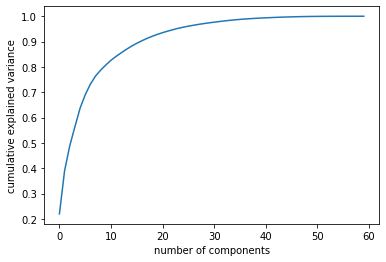

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [23]:
num_components = 40
pca = PCA(num_components)  
X_pca = pca.fit_transform(pwbds_m2) # fit and reduce dimension

In [24]:
X_pca.shape

(51212, 40)

In [25]:
pwbds_scaled_copy = X_pca

In [26]:
num_steps = 5 # Intervalo entre medições é de 2 minutos
#x_new, y_new = lstm_data_transform(pwbds_m2, yds_m2, num_steps=num_steps)
x_new, y_new = lstm_data_transform(X_pca, yds_m2, num_steps=num_steps)

print ("The new shape of x is", x_new.shape)

The new shape of x is (51208, 5, 40)


In [27]:
train_ind = int(0.7 * pwbds_m2.shape[0])
x_train = x_new[:train_ind]
y_train = y_new[:train_ind]
x_test = x_new[train_ind:]
y_test = y_new[train_ind:]

In [28]:
x_test.shape

(15360, 5, 40)

# Model 2

In [29]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras import layers


C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hcord\anaconda3\envs\paper3\lib\site-packages\tensorflow\pyth

In [30]:
print(tf. __version__)
print(np. __version__)
from platform import python_version

print(python_version())

1.14.0
1.19.5
3.6.9


In [31]:
x_train.shape[2]

40

In [32]:
# LSTM model
model = keras.Sequential()

# The first layer
model.add(layers.Bidirectional(layers.LSTM(
         input_shape=(num_steps, x_train.shape[2]),
         units=120,
         activation='tanh',
         return_sequences=True)))
model.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model.add(layers.Dropout(0.2))

# The second layer
model.add(layers.Bidirectional(layers.LSTM(
          units=60,
          return_sequences=False)))
model.add(layers.BatchNormalization())

# Plus a 20% dropout rate
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=30, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=10, activation='relu'))
model.add(layers.Dropout(0.2))

# Dense sigmoid layer
model.add(layers.Dense(units=1, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
adam = keras.optimizers.Adam(lr=0.0001,amsgrad=True)
adagrad = keras.optimizers.Adagrad(learning_rate=0.0001,initial_accumulator_value=0.1, epsilon=1e-07)
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001,rho=0.9, momentum=0.001, epsilon=1e-07)

metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.BinaryAccuracy(name="accuracy")
]

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
# EarlyStopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [34]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=60,
#    batch_size=60,
    validation_split=0.10,
    callbacks = [callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 32263 samples, validate on 3585 samples
Epoch 1/60
32263/32263 [==============================] - 22s 689us/sample - loss: 0.5370 - fn: 5292.0000 - fp: 3801.0000 - tn: 19818.0000 - tp: 3352.0000 - precision: 0.4686 - recall: 0.3878 - accuracy: 0.7182 - val_loss: 0.4398 - val_fn: 726.0000 - val_fp: 161.0000 - val_tn: 2405.0000 - val_tp: 293.0000 - val_precision: 0.6454 - val_recall: 0.2875 - val_accuracy: 0.7526
Epoch 2/60
32263/32263 [==============================] - 22s 666us/sample - loss: 0.4273 - fn: 4840.0000 - fp: 1795.0000 - tn: 21824.0000 - tp: 3804.0000 - precision: 0.6794 - recall: 0.4401 - accuracy: 0.7943 - val_loss: 0.3616 - val_fn: 549.0000 - val_fp: 156.0000 - val_tn: 2410.0000 - val_tp: 470.0000 - val_precision: 0.7508 - val_recall: 0.4612 - val_accuracy: 0.8033
Epoch 3/60
32263/32263 [==============================] - 21s 665us/sample - loss: 0.3716 - fn: 3847.0000 -

32263/32263 [==============================] - 22s 679us/sample - loss: 0.1012 - fn: 530.0000 - fp: 658.0000 - tn: 22961.0000 - tp: 8114.0000 - precision: 0.9250 - recall: 0.9387 - accuracy: 0.9632 - val_loss: 0.0591 - val_fn: 15.0000 - val_fp: 57.0000 - val_tn: 2509.0000 - val_tp: 1004.0000 - val_precision: 0.9463 - val_recall: 0.9853 - val_accuracy: 0.9799
Epoch 22/60
32263/32263 [==============================] - 22s 676us/sample - loss: 0.0956 - fn: 537.0000 - fp: 613.0000 - tn: 23006.0000 - tp: 8107.0000 - precision: 0.9297 - recall: 0.9379 - accuracy: 0.9644 - val_loss: 0.0600 - val_fn: 32.0000 - val_fp: 47.0000 - val_tn: 2519.0000 - val_tp: 987.0000 - val_precision: 0.9545 - val_recall: 0.9686 - val_accuracy: 0.9780
Epoch 23/60
32263/32263 [==============================] - 22s 673us/sample - loss: 0.0941 - fn: 499.0000 - fp: 595.0000 - tn: 23024.0000 - tp: 8145.0000 - precision: 0.9319 - recall: 0.9423 - accuracy: 0.9661 - val_loss: 0.0560 - val_fn: 22.0000 - val_fp: 48.0000 - 

32263/32263 [==============================] - 21s 664us/sample - loss: 0.0545 - fn: 289.0000 - fp: 301.0000 - tn: 23318.0000 - tp: 8355.0000 - precision: 0.9652 - recall: 0.9666 - accuracy: 0.9817 - val_loss: 0.0384 - val_fn: 13.0000 - val_fp: 30.0000 - val_tn: 2536.0000 - val_tp: 1006.0000 - val_precision: 0.9710 - val_recall: 0.9872 - val_accuracy: 0.9880
Epoch 44/60
32263/32263 [==============================] - 22s 686us/sample - loss: 0.0523 - fn: 269.0000 - fp: 300.0000 - tn: 23319.0000 - tp: 8375.0000 - precision: 0.9654 - recall: 0.9689 - accuracy: 0.9824 - val_loss: 0.0447 - val_fn: 19.0000 - val_fp: 31.0000 - val_tn: 2535.0000 - val_tp: 1000.0000 - val_precision: 0.9699 - val_recall: 0.9814 - val_accuracy: 0.9861
Epoch 45/60
32263/32263 [==============================] - 22s 692us/sample - loss: 0.0522 - fn: 277.0000 - fp: 305.0000 - tn: 23314.0000 - tp: 8367.0000 - precision: 0.9648 - recall: 0.9680 - accuracy: 0.9820 - val_loss: 0.0394 - val_fn: 17.0000 - val_fp: 30.0000 -

In [48]:
# Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  154560    
_________________________________________________________________
batch_normalization (BatchNo multiple                  960       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  144480    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  480       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3

In [49]:
x_test.shape

(15360, 5, 40)

Text(0.5, 0, 'epochs')

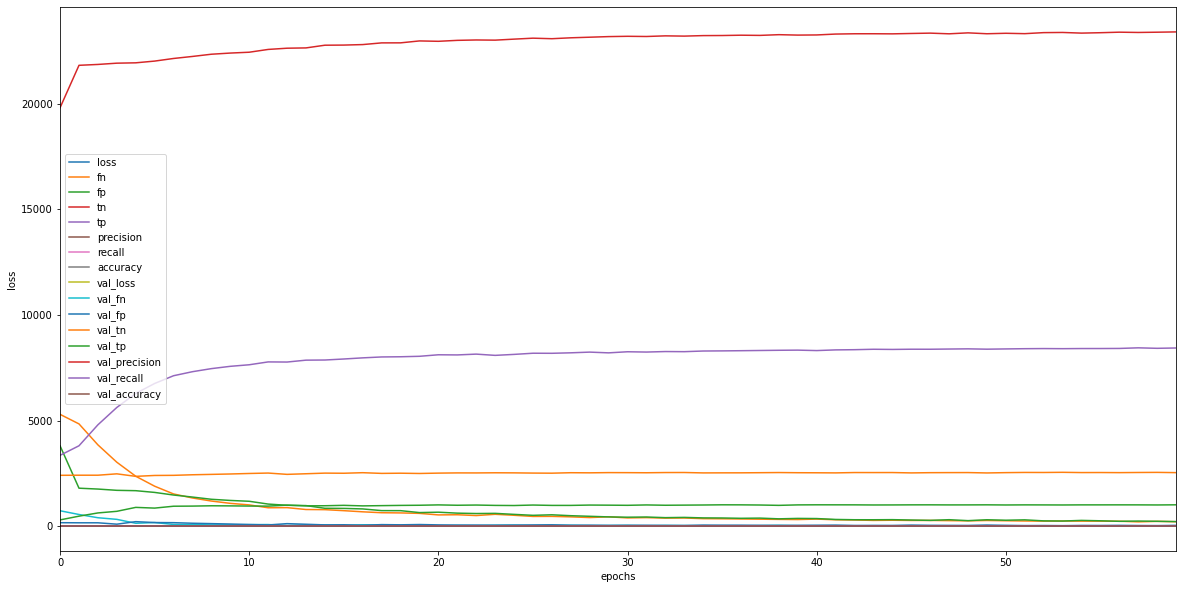

In [50]:
# Plot History
pd.DataFrame(history.history).plot(figsize=(20, 10))
plt.ylabel('loss')
plt.xlabel('epochs')


In [51]:
#scores_2 = model.evaluate(x_test, y_test, verbose=1, batch_size=200)
scores_2 = model.evaluate(x_test, y_test, verbose=1)
print('Test Accurracy: {}'.format(scores_2[1]))

15360/15360 [==============================] - 2s 117us/sample - loss: 0.0220 - fn: 21.0000 - fp: 85.0000 - tn: 11318.0000 - tp: 3936.0000 - precision: 0.9789 - recall: 0.9947 - accuracy: 0.9931
Test Accurracy: 21.0


In [52]:
x_test.shape

(15360, 5, 40)

In [53]:
# make predictions and compute confusion matrix
#y_pred = model.predict_classes(x_test,verbose=1, batch_size=200)
y_pred = model.predict_classes(x_test,verbose=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
cm

15360/15360 [==============================] - 2s 108us/sample


array([[11318,    85],
       [   21,  3936]], dtype=int64)

In [54]:
# compute precision and recall
accuracy_test = accuracy_score(y_true, y_pred)
precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n','Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.9930989583333333 
 Test Precision:  0.9788609798557573 
 Test Recall:  0.9946929492039424 
 Test F1 Score: 0.9867134620205564


In [55]:
cm = confusion_matrix(y_true, y_pred)
cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)
print(cmtx)

        pred:0  pred:1
true:0   11318      85
true:1      21    3936


In [56]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([11403,  3957], dtype=int64))

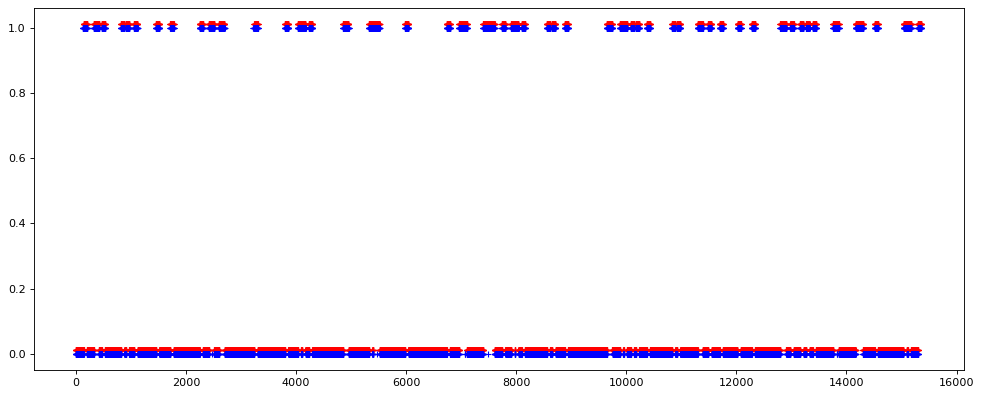

In [57]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_true+0.01,'r+')
plt.plot(y_pred,'b+')

In [58]:
import shap  # package used to calculate Shap values

# use Deep SHAP to explain test set predictions
#k_explainer = shap.KernelExplainer(model_1.predict_proba, x_test)
#k_shap_values = k_explainer.shap_values(x_test.reshape(14315*30,32))
#shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], x_test)

## Salvando o modelo

In [59]:
model.save('../data/pwb_classification_noavalanche')

# Random Forest

In [61]:
train_ind = int(0.7 * pwbds_scaled_copy.shape[0])
x_train = pwbds_scaled_copy[:train_ind]
y_train = clean_ds.NEXT_H[:train_ind]
x_test = pwbds_scaled_copy[train_ind:]
y_test = clean_ds.NEXT_H[train_ind:]

In [62]:
from sklearn.ensemble import RandomForestClassifier as rfc
clf_rf = rfc(random_state=0).fit(x_train, y_train)

In [65]:
clf_rf.score(x_test, y_test)

1.0

In [66]:
y_pred = clf_rf.predict(x_test)

In [67]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[11407,     0],
       [    0,  3957]], dtype=int64)

In [68]:
# compute precision and recall
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  1.0 
 Test Precision:  1.0 
 Test Recall:  1.0 
 Test F1 Score: 1.0


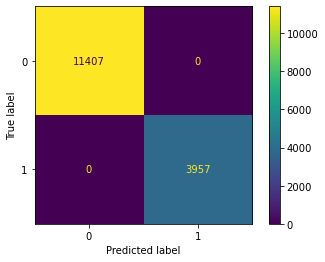

In [69]:
plot_confusion_matrix(clf_rf, x_test, y_test)

In [70]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
#explainer = shap.TreeExplainer(clf_rf)

# Calculate Shap values
#shap_values = explainer.shap_values(x_test)

#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], x_test)


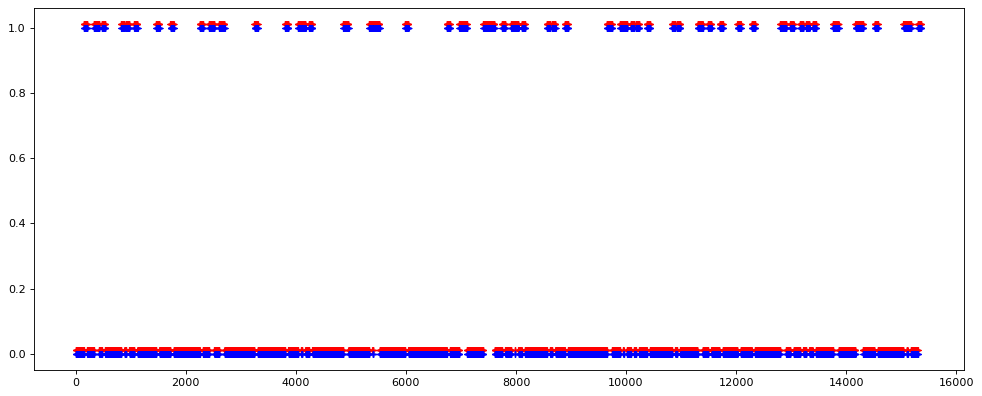

In [71]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_true+0.01,'r+')
plt.plot(y_pred,'b+')

In [72]:
import joblib
filename = '../data/pwb_classification_rf_no_avalanche'
joblib.dump(clf_rf, filename)

['../data/pwb_classification_rf_no_avalanche']

# XGBoost

In [73]:
from sklearn.ensemble import GradientBoostingClassifier as xgb

xgbclf = xgb(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
xgbclf.score(x_test, y_test)


0.8466545170528508

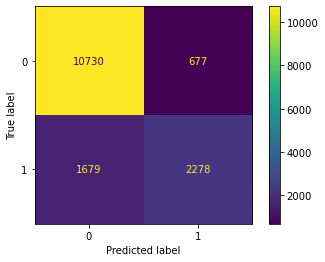

In [74]:
plot_confusion_matrix(xgbclf, x_test, y_test)

In [75]:
y_pred = xgbclf.predict(x_test)

In [76]:
y_test = y_test.reset_index(drop=True)

In [77]:
# compute precision and recall
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.8466545170528508 
 Test Precision:  0.770896785109983 
 Test Recall:  0.5756886530199646 
 Test F1 Score: 0.6591435185185186


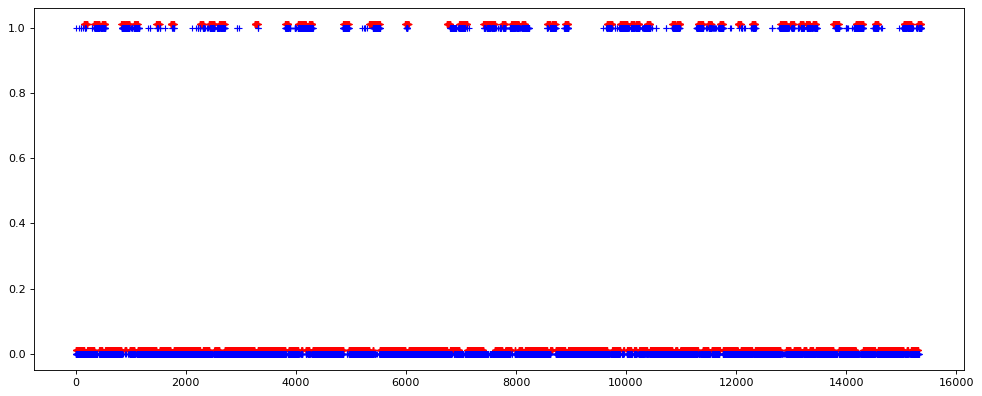

In [78]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_test+0.01,'r+')
plt.plot(y_pred,'b+')

In [79]:
filename = '../data/pwb_classification_xgb_no_avalanche'
joblib.dump(xgbclf, filename)

['../data/pwb_classification_xgb_no_avalanche']